Scratch Jupyter Noteboook

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# Generate 100 random samples in the unit hypersphere (start with 2d)
    # this gives us 100 neurons with "preferred directions" 
# define nonlinear function 
# plot random samples

# given random samples, pass through e1 = [1, 0], and e2[0, 1] to get x and y values respectively of output.  
    # by pass through a vector x we mean 
        # 1 dot product x with each neuron's weight vector (preferred direction)
        # 2 apply nonlinear transformation, to the resulting scalar value. 
        # this gives us a 100 x 2 vector of outputs where we can see the transformation that occurs. 
        
    # do this NUM_LAYERS times and observe the results
    
    
    # now do this in the chaotic regime r ~> 3.59 

Text(0.5, 1.0, "Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")

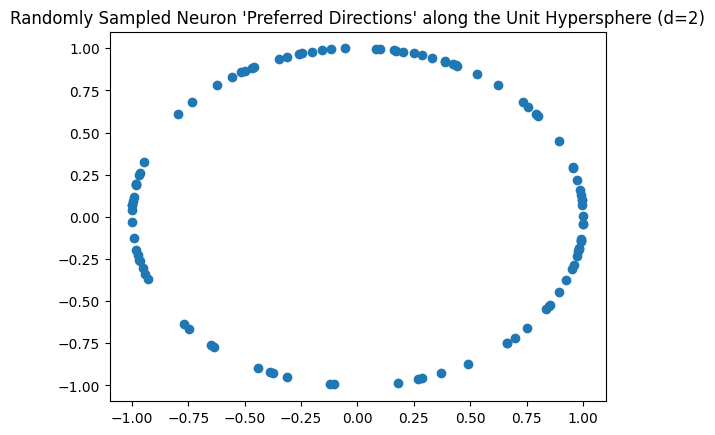

In [8]:
neurons = np.random.normal(loc=0, scale=1, size=(2,100))
neurons = neurons / np.linalg.norm(neurons, axis=0)
plt.scatter(neurons[0,:], neurons[1,:])
plt.title("Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")

In [178]:
def logi(x: float | np.ndarray, r: float) ->  float | np.ndarray :
    return r * x * (1 - x)

def gauss(x: float | np.ndarray, alpha: float, beta: float) -> float | np.ndarray:
    return np.exp(- alpha * np.square(x)) + beta

def forward_pass(neurons: np.ndarray, vector: np.ndarray, step_count: int, r: float) -> np.ndarray:
    if not  neurons.shape[0] == len(vector):
        raise ValueError(f"Could not dot vector with shape {vector.shape} against neurons with shape(s) {neurons.shape}")
    
    dot_prods = vector @ neurons
    if step_count == 0:
        return dot_prods
    else:    
        # transformed = logi(dot_prods, r=r)
        transformed = gauss(dot_prods, alpha=6.20, beta=-.5)
        for step in range(1, step_count):
            # transformed = logi(transformed, r=r)
            transformed = gauss(transformed, alpha=6.20, beta=-.5)
        return transformed * np.sign(neurons)

In [179]:
neurons[:,1]
np.sign(neurons)

array([[ 1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,
         1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,
        -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,
         1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
         1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
         1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.],
       [ 1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
         1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,
         1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,
         1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
         1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1

/tmp/ipykernel_5003/4144032154.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('inferno', num_passes+1)
/tmp/ipykernel_5003/4144032154.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(out_1x, out_1y, label=f"Pass {j+1}", c=colors(j+1))


(-1.25, 1.25)

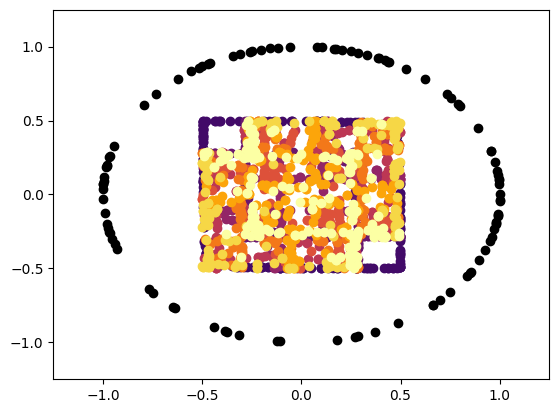

In [ ]:
e1 = np.array([1, 0])
e2 = np.array([0, 1])

num_passes = 10
params = {
    'alpha': 6.5,
    'beta': -.5,
    'r': 3.8,
}
colors = cm.get_cmap('inferno', num_passes+1)

plt.scatter(neurons[0,:], neurons[1,:], color="black")
for j in range(1,num_passes): 
    out_1x = forward_pass(neurons, e1, step_count=j, params=params)
    out_1y = forward_pass(neurons, e2, step_count=j, params=params)

    # out_2x = forward_pass(neurons, -e1, step_count=j, r=r)
    # out_2y = forward_pass(neurons, e2, step_count=j, r=r)

    # out_3x = forward_pass(neurons, -e1, step_count=j, r=r)
    # out_3y = forward_pass(neurons, -e2, step_count=j, r=r)

    # out_4x = forward_pass(neurons, e1, step_count=j, r=r)
    # out_4y = forward_pass(neurons, -e2, step_count=j, r=r)

    plt.scatter(out_1x, out_1y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_2x, out_2y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_3x, out_3y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_4x, out_4y, label=f"Pass {j+1}", c=colors(j+1))

    
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
# plt.legend()

In [119]:
np.min(out_1)

np.float64(-7.971507227600286)